---

In [1]:
import matplotlib.pyplot as plt
import geopandas
import pandas as pd
import locale
import os
import os.path as osp
from typing import List, Dict, Set, Callable

HOME = "../../"
DATA = osp.join(HOME, "data")
CODE = osp.join(HOME, "code")
GREENSPACE_DATA = osp.join(DATA, "greenspace_data")
CENSUS_DATA = osp.join(DATA, "census_code_mappers")
HEALTH_DATA = osp.join(DATA, "")

STATES = geopandas.read_file('./state_shape_data/usa-states-census-2014.shp')
STATES.crs
STATES = STATES.to_crs("EPSG:3395")

In [2]:
def plot_on_US_map(
    fnc: Callable[[pd.Series], int], 
    col_name: str
):
    STATES[col_name] = STATES.apply(fnc, axis = 1)
    STATES.plot(column = col_name, legend = True)
    plt.title("How "+str(col_name)+" varies by state")
    plt.show()

Getting all the locational dataframes

In [10]:
city_df = pd.read_csv(osp.join(CENSUS_DATA, "us_city_info.csv"))
blocks_df = pd.read_csv(osp.join(CENSUS_DATA, "us_blocks.csv"))
fips_df = pd.read_csv(osp.join(CENSUS_DATA, "fips_codes.csv"))

# Getting some dictionaries from the blocks_df
dc_block_geo_id_state_fip = dict(zip(blocks_df.block_geoid, blocks_df.state_fip))
dc_block_geo_id_county_fip = dict(zip(blocks_df.block_geoid, blocks_df.county_fip))
dc_block_geo_id_county_name = dict(zip(blocks_df.block_geoid, blocks_df.county_name))

# Getting dictionaries from the fips_df
dc_state_fip_to_state_abb = dict(zip(fips_df.state_code, fips_df.state))

# Getting dictionaries from the city_df
dc_county_fips_to_state_name =  dict(zip(city_df.county_fips, city_df.state_abbr))
dc_city_name_to_state_name =  dict(zip(city_df.city, city_df.state_abbr))

# blocks_df.sample(10)

In [4]:
tree_df = pd.read_csv(osp.join(HOME, "data/greenspace_data/5_million_trees_us_cities.csv"))
pcc = pd.read_csv(osp.join(GREENSPACE_DATA, "percent_cover_county.txt"))
urban_tree_canopy_df = pd.read_csv(osp.join(GREENSPACE_DATA,"urban_tree_canopy.csv"))

/var/folders/pl/tr7722ys2bdgctv1qd3njn380000gn/T/ipykernel_15816/2086740513.py:1: DtypeWarning: Columns (0,1,7,8,9,10,12,14,16,18,19,20,21,22,23,24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  tree_df = pd.read_csv(osp.join(HOME, "data/greenspace_data/5_million_trees_us_cities.csv"))


In [5]:
pcc['state'] = pcc.apply(
    lambda row: dc_county_fips_to_state_name[row.GEOID] if(row.GEOID in dc_county_fips_to_state_name) else 0,
    axis=1
)
    
urban_tree_canopy_df['state'] =  urban_tree_canopy_df.apply(
    lambda row: dc_state_fip_to_state_abb[dc_block_geo_id_state_fip[int(row.census_block)]] 
    if (
        row.census_block in dc_block_geo_id_state_fip and 
        dc_block_geo_id_state_fip[int(row.census_block)] in dc_state_fip_to_state_abb) else row.city_name[-2:],
    axis = 1
)
urban_tree_canopy_df.sample(5)

,city_name,census_block,mean_percent_tree_cover,tree_gap,surface_temp,income_percent,income_group,pop_dens_group,state
593050,"Albany--Schenectady, NY",3.609302e+14,0.220829,0.444941,25.727778,17905,1,1,NY
1138124,"Baton Rouge, LA",2.203300e+14,0.134548,0.665199,29.091667,22588,2,1,LA
1778077,"Louisville/Jefferson County, KY--IN",2.111101e+14,0.256362,0.468931,28.180556,30410,3,1,KY
1049639,"Chicago, IL--IN",1.704384e+14,0.288177,0.469321,27.879412,19049,1,1,IL
167161,"Orlando, FL",1.209502e+14,0.325856,0.384567,29.100000,24522,2,2,FL


---

In [6]:
avg_pcc = pcc.groupby(['state']).mean()['pc_park'].to_dict()
avg_urban_canopy_per_city = urban_tree_canopy_df.groupby(['state']).mean()['mean_percent_tree_cover'].to_dict()
dc = tree_df.groupby(['state']).count()['city'].to_dict()

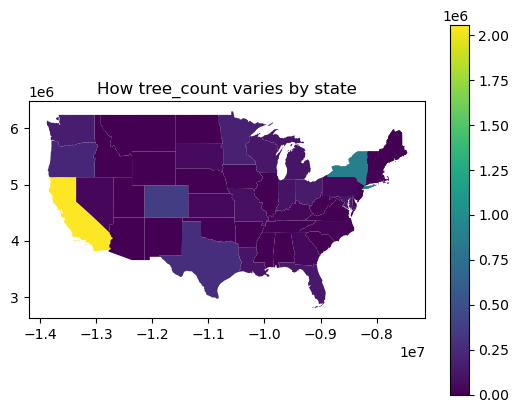

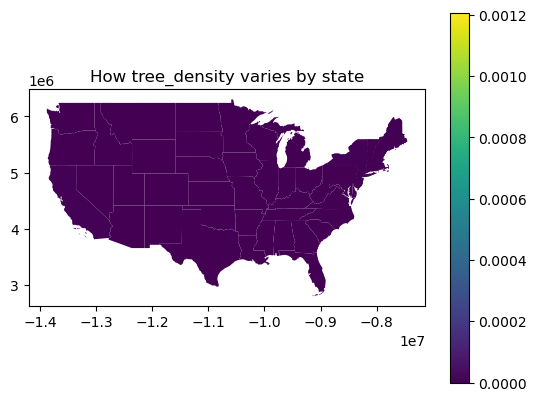

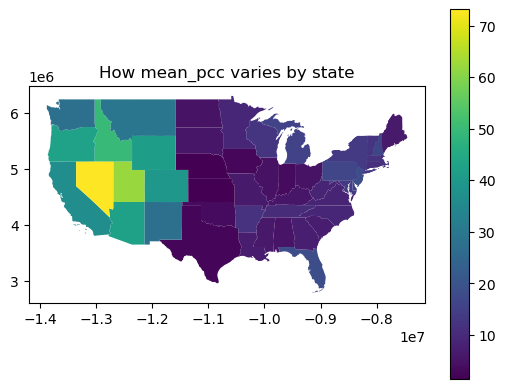

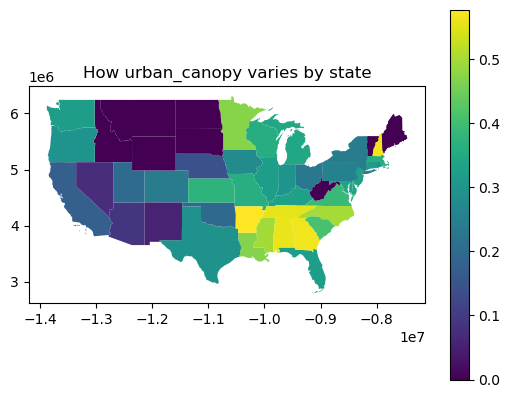

In [7]:
plot_on_US_map(lambda row: dc[row.NAME] if row.NAME in dc else 0, 'tree_count')
plot_on_US_map(lambda row: row.tree_count / row.ALAND, 'tree_density')
plot_on_US_map(lambda row: avg_pcc[row.STUSPS], 'mean_pcc')
plot_on_US_map(lambda row: avg_urban_canopy_per_city[row.STUSPS] if row.STUSPS in avg_urban_canopy_per_city else 0, 'urban_canopy')